In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import cv2
import shutil
from datetime import datetime
from mtcnn import MTCNN
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image

2024-03-03 09:48:59.511406: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Date preperation

In [38]:
# Define paths to your training and testing directories
data_dir = 'Datasets/combined_dataset_processed_128_1'

# Function to add images from a directory to a list
def process_directory(directory, data_list):
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)

        # Check if it's a directory
        if os.path.isdir(class_dir):
            # Loop through each image in the folder
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                # For test purposes use only processed images that DeepFace classifies correctly
                # processed_image_path = image_path.replace('combined_dataset_deepface', 'combined_dataset_processed')
                # Append to the data list
                data_list.append({'filepath': image_path, 'label': class_name})

# Initialize an empty list for storing data
data_list = []
# Add training images to the data list
process_directory(data_dir, data_list)
# Create a DataFrame from the list
df = pd.DataFrame(data_list)
# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
# Print the amount of images per category before balancing
print("Images per category:")
print(df['label'].value_counts())

# Split the data into training, validation, and test sets
train_df, temp_test_val_df = train_test_split(df, train_size=0.7, random_state=42)
test_df, val_df = train_test_split(temp_test_val_df, test_size=0.5, random_state=42)

# Balance the test and validation sets
# Determine the smallest class size within each of the test and validation sets
min_test_class_size = test_df['label'].value_counts().min()
min_val_class_size = val_df['label'].value_counts().min()

# Determine the smallest size between the two for a uniform approach
uniform_min_size = min(min_test_class_size, min_val_class_size)

# Function to reduce class sizes
def balance_classes(df, target_size):
    balanced_df = pd.DataFrame()  # Initialize an empty DataFrame to hold the balanced data
    for label in df['label'].unique():
        subset = df[df['label'] == label].sample(n=target_size, random_state=42)
        balanced_df = pd.concat([balanced_df, subset])
    return balanced_df

# Apply balancing
test_df = balance_classes(test_df, uniform_min_size)
val_df = balance_classes(val_df, uniform_min_size)

# Calculate and print split ratios
total_samples = len(df)
train_ratio = len(train_df) / total_samples
val_ratio = len(val_df) / total_samples
test_ratio = len(test_df) / total_samples

print(f"\nTotal samples: {total_samples}")
print(f"Training set: {train_ratio:.2f} ({len(train_df)} samples)")
print(f"Validation set: {val_ratio:.2f} ({len(val_df)} samples)")
print(f"Test set: {test_ratio:.2f} ({len(test_df)} samples)\n")

Images per category:
label
happy       17299
neutral     12928
sad         11161
angry        9415
surprise     9302
fear         8649
disgust      4767
Name: count, dtype: int64

Training set size: 51464
Balanced Test set size: 4949
Balanced Validation set size: 4949

Total samples: 73521
Training set: 0.70 (51464 samples)
Validation set: 0.07 (4949 samples)
Test set: 0.07 (4949 samples)


# Preprocessing

In [25]:
# Set the image size and batch size
image_size = (128, 128)
batch_size = 64

# Create an ImageDataGenerator for data augmentation (optional)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    # rotation_range=15,  # rotation. Not needed since all images are getting aligned
    width_shift_range=0.05, # horizontal shift (only 5% since faces are centered)
    height_shift_range=0.05, # vertical shift (only 5% since faces are centered)
    shear_range=0.1, 
    # zoom_range=0.1,   zoom (with current dataset not needed, since faces are centered)
    horizontal_flip=True, # flip images horizontally
    fill_mode='constant' # fill in missing pixels (nearest / constant)
    # brightness_range=[0.8, 1.2] # darken and lighten images
) 

# train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation data
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test data

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
# Assuming 'labels' contains your class labels for the training data
labels = train_df['label'].values
unique_classes = np.unique(labels)
# Compute class weights for balanced training
class_weights = compute_class_weight('balanced', classes=unique_classes, y=labels)
# Get class indices from the generator
class_indices = train_generator.class_indices
# Ensure the order of `unique_classes` matches the order in `class_indices`
ordered_unique_classes = sorted(unique_classes, key=lambda x: class_indices[x])
# Create a dictionary mapping class indices to their weights
class_weights_dict = {class_indices[label]: weight for label, weight in zip(ordered_unique_classes, class_weights)}
print(class_weights_dict)

Found 58816 validated image filenames belonging to 7 classes.
Found 3178 validated image filenames belonging to 7 classes.
Found 3178 validated image filenames belonging to 7 classes.
{0: 1.1168796642676744, 1: 2.209964680243481, 2: 1.2119263975603223, 3: 0.6077602686644278, 4: 0.8153600887225342, 5: 0.9431233263313182, 6: 1.1174738282066383}


# Image before and after preprocessing comparison

In [31]:
# Create a non-preprocessing ImageDataGenerator
no_preprocessing_datagen = ImageDataGenerator()

# Create a temporary generator to fetch a batch of original images
temp_generator = no_preprocessing_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
    #shuffle=True  # Keep the same order as the original generator
)

# Function to plot images in a grid
def plot_images_before(images_arr):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'))  # Cast to uint8 for correct image display
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Fetch a batch of original images
original_batch = next(temp_generator)
original_images = original_batch[0][:9]  # Select first 25 images

# Function to plot images in a grid
def plot_images_after(images_arr):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap='gray')  # Set the colormap to 'gray'
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images
example_batch = next(train_generator)
example_images = example_batch[0][:9]  # Select first 25 images

# Plot the images
plot_images_before(original_images)
plot_images_after(example_images)

Found 73521 images belonging to 7 classes.


# Model Definition
Previous model architecture neurons per layer: 
1. Start with images size (e.g. 224 for RAF-DB, 48 for FER2013) and divide by 2 for each convolutional layer
2. Pyramidal model: double the number of filters for each convolutional layer, then halve the number of filters for each convolutional layer (e.g. 64, 128, 256, 128, 64)

batch_size = 64, learning_rate = 0.0002, l2_reg = 0.002 and dropout = [0.1,0.3] give accuracy of about 50% 062527, 084021 
batch_size = 64, learning_rate = 0.0002, l2_reg = 0.004 and dropout = [0.3,0.5] doesn't work, on about epoch 4-6 jumps in accuracy in loss and accuracy. Correction: better results are achieved. Overfitting was reduced. 090307, 101603
batch_size = 256, learning_rate = 0.001, l2_reg = 0.004 and dropout = [0.3,0.5] very bad results. Probably learning rate

model_checkpoint_20240224_170704.keras using new dataset
model_checkpoint_20240225_085054.keras using DeepFace detected emotion images

In [32]:
input_shape = (128, 128, 1)
l2_reg = 0.001  # Regularization strength
dropout = [0.15, 0,4]
n_filter = [128, 64, 32, 128]

model = Sequential([
    # First Conv Block
    Conv2D(n_filter[0], (3, 3), padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=l2(l2_reg)), 
    BatchNormalization(), # Batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation
    MaxPooling2D(pool_size=(2, 2)), # Max pooling reduces computation by reducing the dimensionality of the feature maps
    Dropout(dropout[0]), # Dropout to prevent overfitting
    # Second Conv Block
    Conv2D(n_filter[1], (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(dropout[0]),
    # Third Conv Block
    Conv2D(n_filter[2], (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(dropout[0]),
    # Flatten and Dense Layers
    Flatten(),
    Dense(n_filter[3], activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    Dropout(dropout[1]),
    Dense(7, activation='softmax', kernel_regularizer=l2(l2_reg))  # 7 emotions
])

model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

# Callbacks

In [33]:
# Early stopping to prevent overfitting. This stops training when the model's performance on the validation set starts to degrade.
early_stopper = EarlyStopping(
    monitor='val_loss',  # Metric to be monitored
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

# ModelCheckpoint callback
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint = ModelCheckpoint(
    f'logs/model_checkpoint_{timestamp}.keras',  # Path where to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=False,    # Save only the best model. Set False to save the model at the end of every epoch so restarting from specific epoch is possible
    save_weights_only=False, # Save only the weights
    mode='min',             # Minimize the monitored metric (val_loss) min before
    verbose=1               # Verbose output
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001,
    cooldown=3,
    verbose=1
)

# Model Training

In [34]:
# Load the last saved weights
# model.load_weights('logs/model_checkpoint_20240225_085054.keras')

 # When resuming training, set epochs to the total number of epochs you want to train, not just the additional epochs. The model.fit() method continues training for the specified number of epochs, starting from the current epoch count.
epochs = 50

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights_dict,
    callbacks=[early_stopper, checkpoint, reduce_lr]
)

# Save the training history for later analysis
with open(f'logs/training_history_{timestamp}.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/30
919/919 [==============================] - ETA: 0s - loss: 2.0970 - accuracy: 0.3467
Epoch 1: saving model to logs/model_checkpoint_20240302_144809.keras
919/919 [==============================] - 1674s 2s/step - loss: 2.0970 - accuracy: 0.3467 - val_loss: 2.2297 - val_accuracy: 0.2883 - lr: 0.0015
Epoch 2/30
919/919 [==============================] - ETA: 0s - loss: 1.8082 - accuracy: 0.4431
Epoch 2: saving model to logs/model_checkpoint_20240302_144809.keras
919/919 [==============================] - 1689s 2s/step - loss: 1.8082 - accuracy: 0.4431 - val_loss: 1.8486 - val_accuracy: 0.3967 - lr: 0.0015
Epoch 3/30
461/919 [==============>...............] - ETA: 13:34 - loss: 1.7451 - accuracy: 0.4740

KeyboardInterrupt: 

# Evaluation and Visualization

50/50 [==============================] - 18s 354ms/step - loss: 1.8026 - accuracy: 0.4352
Test accuracy:  0.43517935276031494
50/50 [==============================] - 18s 365ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.45      0.35      0.39       454
     disgust       0.51      0.23      0.32       454
        fear       0.41      0.39      0.40       454
       happy       0.69      0.74      0.72       454
     neutral       0.40      0.39      0.40       454
         sad       0.28      0.68      0.40       454
    surprise       0.72      0.26      0.38       454

    accuracy                           0.44      3178
   macro avg       0.50      0.44      0.43      3178
weighted avg       0.50      0.44      0.43      3178

Weighted Precision: 0.4951279749274118
Weighted Recall: 0.4351793580868471
Weighted F1-Score: 0.42892199650350715


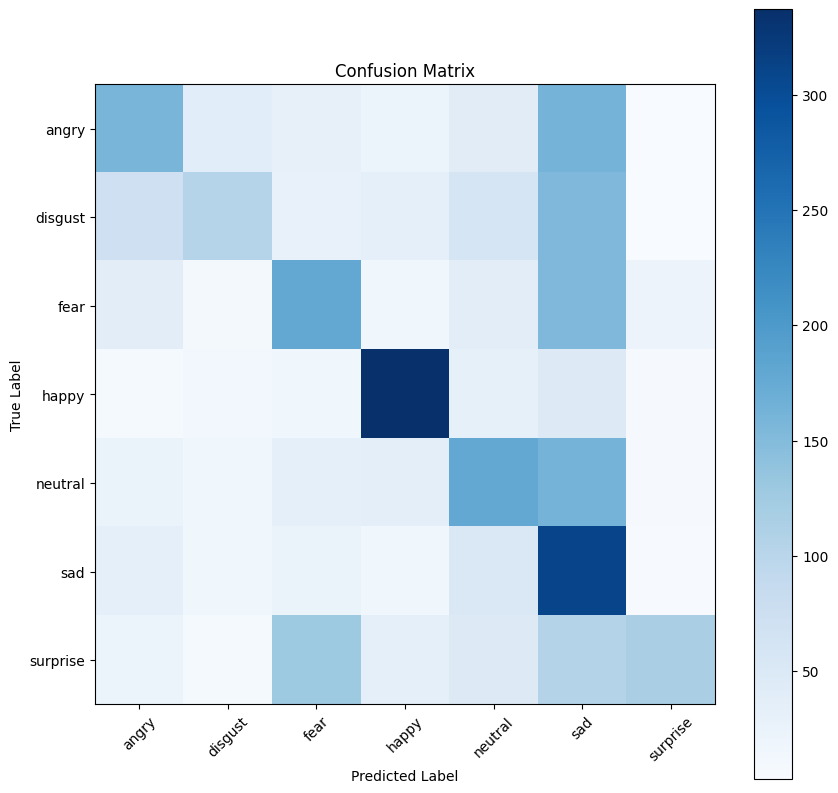

In [35]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
print("Test accuracy: ", test_accuracy)

# Predictions on the test set
test_generator.reset() # Ensuring the generator is reset to the beginning
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1) # Convert predictions to class labels

# Since the generator omits some samples due to rounding down in 'steps', trim 'true_classes' to match 'predicted_classes' length
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

# Additional weighted metric calculations
weighted_precision = precision_score(true_classes, predicted_classes, average='weighted')
weighted_recall = recall_score(true_classes, predicted_classes, average='weighted')
weighted_f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("Weighted F1-Score:", weighted_f1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Conducting error analysis
This can be done by examining misclassified examples, which can provide insights into what types of errors the model is making

In [36]:
# Learning Curves
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

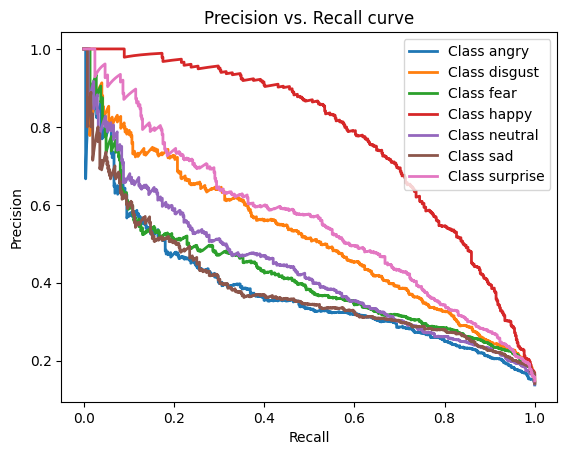

In [30]:
# Precsion-Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class
y_bin = label_binarize(true_classes, classes=np.arange(len(class_labels)))
n_classes = y_bin.shape[1]

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], predictions[:, i])

# Plot the precision-recall curve
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(class_labels[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

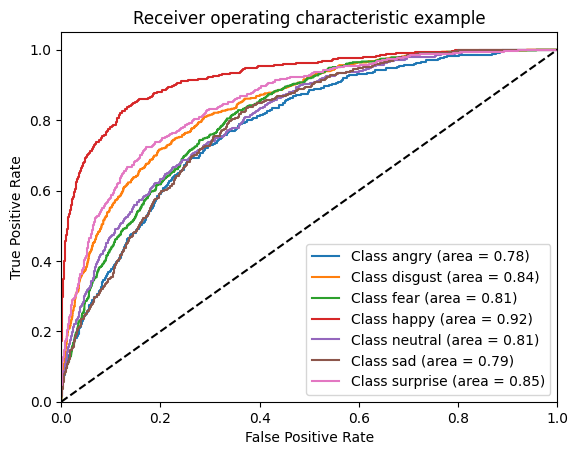

In [31]:
# ROC Curve and AUC
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()